In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as pyplot
import gdal
import geopandas
import pandas as pd
import numpy as np
import copy
import ogr, os
import shapely

In [2]:
expol = geopandas.read_file("Polygons/buildings.shp")

In [ ]:
expol

In [4]:
x = expol.geometry.boundary

In [6]:
expol.geometry = x

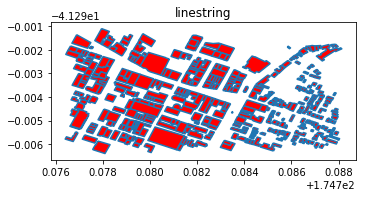

In [8]:
fig = pyplot.figure(figsize=(12,12))

ax1 = fig.add_subplot(221)
ax1.set_title("linestring")
expol.plot(ax=ax1, facecolor='Red')